In [26]:
import os
import dataloader
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from loss_func import FocalLoss
from models.model_collects import *

from models import Transformer
import matplotlib.pyplot as plt
import torchinfo

In [2]:
log_path = 'logs/HDFS_2k.log_structured.csv'
label_path = 'logs/anomaly_label.csv'
template_path = 'logs/HDFS_2k.log_templates.csv'

x_train, y_train, x_test, y_test = dataloader.load_HDFS(
    log_file=log_path,
    label_file=label_path,
    template_file=template_path,
    train_ratio=0.7,
    save_csv=False)

num_val = x_train.shape[0] // 10
num_train = x_train.shape[0] - num_val

x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train = x_train[num_val:]
y_train = y_train[num_val:]

num_test = x_test.shape[0]
num_total = num_train + num_val + num_test

num_train_pos = sum(y_train)
num_val_pos = sum(y_val)
num_test_pos = sum(y_val)
num_pos = num_train_pos + num_val_pos + num_test_pos

print('Total: {} instances, {} anomaly, {} normal' \
      .format(num_total, num_pos, num_total - num_pos))
print('Train: {} instances, {} anomaly, {} normal' \
      .format(num_train, num_train_pos, num_train - num_train_pos))
print('Validation: {} instances, {} anomaly, {} normal' \
      .format(num_val, num_val_pos, num_val - num_val_pos))
print('Test: {} instances, {} anomaly, {} normal\n' \
      .format(num_test, num_test_pos, num_test - num_test_pos))

Total: 2200 instances, 57 anomaly, 2143 normal
Train: 1386 instances, 49 anomaly, 1337 normal
Validation: 154 instances, 4 anomaly, 150 normal
Test: 660 instances, 4 anomaly, 656 normal



In [3]:
batch_size = 512
lr = 0.001
num_epochs = 300
max_length = x_train.shape[1]
input_shape = x_train.shape[1:]
val_interval = 1

x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train).to(torch.int64)
y_train_tensor = F.one_hot(y_train_tensor, num_classes=2)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor.to(torch.float))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_val_tensor = torch.Tensor(x_val)
y_val_tensor = torch.Tensor(y_val).to(torch.int64)
y_val_tensor = F.one_hot(y_val_tensor, num_classes=2)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor.to(torch.float))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
model_path = "saved_models"
if not os.path.exists(model_path):
    os.mkdir(model_path)

train_loss_dict = dict()
val_loss_dict = dict()

## Train TransLog

In [5]:
# define model
device = torch.device("mps")
model = TransLog(max_length).to(device)
model_name = "TransLog"
best_model = model

# Loss and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_min = 1e10

train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    val_loss = 0
    # Training
    for step, (seq, label) in enumerate(train_dataloader):
        seq = seq.clone().detach().view(-1, max_length, 1).to(device)
        output = model(seq)
        loss = criterion(output, label.to(device))
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    ave_trainloss = train_loss / len(train_dataloader)
    train_loss_list.append(ave_trainloss)

    # Vaildating
    saved = False
    with torch.no_grad():
        for step, (seq, label) in enumerate(val_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            #loss = criterion(output, label.to(device))
            loss = nn.BCEWithLogitsLoss()(output, label.to(device))
            val_loss += loss.item()

    ave_valoss = val_loss / len(val_dataloader)
    val_loss_list.append(ave_valoss)

    if ave_valoss < loss_min:
        loss_min = ave_valoss
        save_path = os.path.join(model_path, 'best_{}.pth'.format(model_name))
        torch.save(model.state_dict(), save_path)
        best_model = model
        saved = True

    print('epoch [{}/{}], train_loss= {:.10f} val_loss= {:.10f} save= {}'.
          format(epoch, num_epochs, ave_trainloss, ave_valoss, saved))

train_loss_dict[model_name] = train_loss_list
val_loss_dict[model_name] = val_loss_list

epoch [1/300], train_loss= 0.1715829273 val_loss= 0.6860764027 save= True
epoch [2/300], train_loss= 0.1600176692 val_loss= 0.6704142690 save= True
epoch [3/300], train_loss= 0.1567825625 val_loss= 0.6583974957 save= True
epoch [4/300], train_loss= 0.1491245429 val_loss= 0.6528605819 save= True
epoch [5/300], train_loss= 0.1441149116 val_loss= 0.6508521438 save= True
epoch [6/300], train_loss= 0.1372701327 val_loss= 0.6505747437 save= True
epoch [7/300], train_loss= 0.1321284523 val_loss= 0.6506578922 save= False
epoch [8/300], train_loss= 0.1287384629 val_loss= 0.6501635313 save= True
epoch [9/300], train_loss= 0.1260268241 val_loss= 0.6480428576 save= True
epoch [10/300], train_loss= 0.1203285307 val_loss= 0.6430300474 save= True
epoch [11/300], train_loss= 0.1182524239 val_loss= 0.6346699595 save= True
epoch [12/300], train_loss= 0.1135775372 val_loss= 0.6233764291 save= True
epoch [13/300], train_loss= 0.1122229745 val_loss= 0.6134554744 save= True
epoch [14/300], train_loss= 0.108

In [6]:
torchinfo.summary(model,input_size=(batch_size,max_length,1))

Layer (type:depth-idx)                             Output Shape              Param #
TransLog                                           [512, 2]                  --
├─Transformer: 1-1                                 [512, 128]                --
│    └─Linear: 2-1                                 [512, 2, 64]              128
│    └─Dropout: 2-2                                [512, 2, 64]              --
│    └─PositionalEncoding: 2-3                     [512, 2, 64]              --
│    │    └─Dropout: 3-1                           [512, 2, 64]              --
│    └─ModuleList: 2-4                             --                        --
│    │    └─ModuleList: 3-2                        --                        147,968
│    │    └─ModuleList: 3-3                        --                        147,968
│    │    └─ModuleList: 3-4                        --                        147,968
│    │    └─ModuleList: 3-5                        --                        147,968
│    │    └─Mo

## Train Large TransLog

In [7]:
# define model
device = torch.device("mps")
model = Large_TransLog(max_length).to(device)
model_name = "Large_TransLog"
best_model = model

# Loss and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_min = 1e10

train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    val_loss = 0
    # Training
    for step, (seq, label) in enumerate(train_dataloader):
        seq = seq.clone().detach().view(-1, max_length, 1).to(device)
        output = model(seq)
        loss = criterion(output, label.to(device))
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    ave_trainloss = train_loss / len(train_dataloader)
    train_loss_list.append(ave_trainloss)

    # Vaildating
    saved = False
    with torch.no_grad():
        for step, (seq, label) in enumerate(val_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            #loss = criterion(output, label.to(device))
            loss = nn.BCEWithLogitsLoss()(output, label.to(device))
            val_loss += loss.item()

    ave_valoss = val_loss / len(val_dataloader)
    val_loss_list.append(ave_valoss)

    if ave_valoss < loss_min:
        loss_min = ave_valoss
        save_path = os.path.join(model_path, 'best_{}.pth'.format(model_name))
        torch.save(model.state_dict(), save_path)
        best_model = model
        saved = True

    print('epoch [{}/{}], train_loss= {:.10f} val_loss= {:.10f} save= {}'.
          format(epoch, num_epochs, ave_trainloss, ave_valoss, saved))

train_loss_dict[model_name] = train_loss_list
val_loss_dict[model_name] = val_loss_list

epoch [1/300], train_loss= 0.1639045278 val_loss= 0.7071211934 save= True
epoch [2/300], train_loss= 0.1557859033 val_loss= 0.7135559916 save= False
epoch [3/300], train_loss= 0.1507199009 val_loss= 0.7134540081 save= False
epoch [4/300], train_loss= 0.1456376115 val_loss= 0.7120110393 save= False
epoch [5/300], train_loss= 0.1427638878 val_loss= 0.7131910920 save= False
epoch [6/300], train_loss= 0.1410871148 val_loss= 0.7167688608 save= False
epoch [7/300], train_loss= 0.1355874787 val_loss= 0.7216796875 save= False
epoch [8/300], train_loss= 0.1334375764 val_loss= 0.7271806598 save= False
epoch [9/300], train_loss= 0.1301811288 val_loss= 0.7327951789 save= False
epoch [10/300], train_loss= 0.1280510028 val_loss= 0.7383034229 save= False
epoch [11/300], train_loss= 0.1247409433 val_loss= 0.7433898449 save= False
epoch [12/300], train_loss= 0.1213925903 val_loss= 0.7481101751 save= False
epoch [13/300], train_loss= 0.1196974938 val_loss= 0.7524630427 save= False
epoch [14/300], train_

In [8]:
torchinfo.summary(model,input_size=(batch_size,max_length,1))

Layer (type:depth-idx)                             Output Shape              Param #
Large_TransLog                                     [512, 2]                  --
├─Transformer: 1-1                                 [512, 192]                --
│    └─Linear: 2-1                                 [512, 2, 96]              192
│    └─Dropout: 2-2                                [512, 2, 96]              --
│    └─PositionalEncoding: 2-3                     [512, 2, 96]              --
│    │    └─Dropout: 3-1                           [512, 2, 96]              --
│    └─ModuleList: 2-4                             --                        --
│    │    └─ModuleList: 3-2                        --                        234,240
│    │    └─ModuleList: 3-3                        --                        234,240
│    │    └─ModuleList: 3-4                        --                        234,240
│    │    └─ModuleList: 3-5                        --                        234,240
│    │    └─Mo

## Train Mini TransLog

In [27]:
# define model
device = torch.device("cpu")
model = Mini_TransLog(max_length).to(device)
model_name = "Mini_TransLog"
best_model = model

# Loss and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_min = 1e10

train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    val_loss = 0
    # Training
    for step, (seq, label) in enumerate(train_dataloader):
        seq = seq.clone().detach().view(-1, max_length, 1).to(device)
        output = model(seq)
        loss = criterion(output, label.to(device))
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    ave_trainloss = train_loss / len(train_dataloader)
    train_loss_list.append(ave_trainloss)

    # Vaildating
    saved = False
    with torch.no_grad():
        for step, (seq, label) in enumerate(val_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            #loss = criterion(output, label.to(device))
            loss = nn.BCEWithLogitsLoss()(output, label.to(device))
            val_loss += loss.item()

    ave_valoss = val_loss / len(val_dataloader)
    val_loss_list.append(ave_valoss)

    if ave_valoss < loss_min:
        loss_min = ave_valoss
        save_path = os.path.join(model_path, 'best_{}.pth'.format(model_name))
        torch.save(model.state_dict(), save_path)
        best_model = model
        saved = True

    print('epoch [{}/{}], train_loss= {:.10f} val_loss= {:.10f} save= {}'.
          format(epoch, num_epochs, ave_trainloss, ave_valoss, saved))

train_loss_dict[model_name] = train_loss_list
val_loss_dict[model_name] = val_loss_list

epoch [1/300], train_loss= 0.2003773501 val_loss= 0.1242519692 save= True
epoch [2/300], train_loss= 0.1254707153 val_loss= 0.1323866695 save= False
epoch [3/300], train_loss= 0.1022881406 val_loss= 0.2618198693 save= False
epoch [4/300], train_loss= 0.0836796872 val_loss= 0.3256479800 save= False
epoch [5/300], train_loss= 0.0630123653 val_loss= 0.1779067367 save= False
epoch [6/300], train_loss= 0.0692969275 val_loss= 0.2011210918 save= False
epoch [7/300], train_loss= 0.0632015119 val_loss= 0.2989781797 save= False
epoch [8/300], train_loss= 0.0568612839 val_loss= 0.3361122310 save= False
epoch [9/300], train_loss= 0.0576629688 val_loss= 0.2452834696 save= False
epoch [10/300], train_loss= 0.0541126132 val_loss= 0.2286897153 save= False
epoch [11/300], train_loss= 0.0518514973 val_loss= 0.2545424700 save= False
epoch [12/300], train_loss= 0.0509571296 val_loss= 0.2755957544 save= False
epoch [13/300], train_loss= 0.0524810751 val_loss= 0.2931448817 save= False
epoch [14/300], train_

In [28]:
torchinfo.summary(model,input_size=(batch_size,max_length,1))

Layer (type:depth-idx)                             Output Shape              Param #
Mini_TransLog                                      [512, 2]                  --
├─Transformer: 1-1                                 [512, 64]                 --
│    └─Linear: 2-1                                 [512, 2, 32]              64
│    └─Dropout: 2-2                                [512, 2, 32]              --
│    └─PositionalEncoding: 2-3                     [512, 2, 32]              --
│    │    └─Dropout: 3-1                           [512, 2, 32]              --
│    └─ModuleList: 2-4                             --                        --
│    │    └─ModuleList: 3-2                        --                        69,888
│    │    └─ModuleList: 3-3                        --                        69,888
│    │    └─ModuleList: 3-4                        --                        69,888
│    │    └─ModuleList: 3-5                        --                        69,888
├─Linear: 1-2      

## Train DeepLog

In [11]:
# define model
device = torch.device("cpu")
model = DeepLog(input_size = 1, hidden_size=128, device = device).to(device)
model_name = "DeepLog"
best_model = model

# Loss and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_min = 1e10

train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    val_loss = 0
    # Training
    for step, (seq, label) in enumerate(train_dataloader):
        seq = seq.clone().detach().view(-1, max_length, 1).to(device)
        output = model(seq)
        loss = criterion(output, label.to(device))
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    ave_trainloss = train_loss / len(train_dataloader)
    train_loss_list.append(ave_trainloss)

    # Vaildating
    saved = False
    with torch.no_grad():
        for step, (seq, label) in enumerate(val_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            #loss = criterion(output, label.to(device))
            loss = nn.BCEWithLogitsLoss()(output, label.to(device))
            val_loss += loss.item()

    ave_valoss = val_loss / len(val_dataloader)
    val_loss_list.append(ave_valoss)

    if ave_valoss < loss_min:
        loss_min = ave_valoss
        save_path = os.path.join(model_path, 'best_{}.pth'.format(model_name))
        torch.save(model.state_dict(), save_path)
        best_model = model
        saved = True

    print('epoch [{}/{}], train_loss= {:.10f} val_loss= {:.10f} save= {}'.
          format(epoch, num_epochs, ave_trainloss, ave_valoss, saved))

train_loss_dict[model_name] = train_loss_list
val_loss_dict[model_name] = val_loss_list

epoch [1/300], train_loss= 0.1615677377 val_loss= 0.6585631371 save= True
epoch [2/300], train_loss= 0.1501801113 val_loss= 0.6353980899 save= True
epoch [3/300], train_loss= 0.1369788796 val_loss= 0.6037490368 save= True
epoch [4/300], train_loss= 0.1192011734 val_loss= 0.5527612567 save= True
epoch [5/300], train_loss= 0.0942959413 val_loss= 0.4643705189 save= True
epoch [6/300], train_loss= 0.0646800982 val_loss= 0.3334953189 save= True
epoch [7/300], train_loss= 0.0532245748 val_loss= 0.2345238030 save= True
epoch [8/300], train_loss= 0.0550779762 val_loss= 0.2166601419 save= True
epoch [9/300], train_loss= 0.0569904943 val_loss= 0.2322847247 save= False
epoch [10/300], train_loss= 0.0511200254 val_loss= 0.2681584954 save= False
epoch [11/300], train_loss= 0.0474004708 val_loss= 0.3037457764 save= False
epoch [12/300], train_loss= 0.0459093253 val_loss= 0.3275358081 save= False
epoch [13/300], train_loss= 0.0475917036 val_loss= 0.3313334882 save= False
epoch [14/300], train_loss= 0

In [12]:
torchinfo.summary(model,input_size=(batch_size,max_length,1))

Layer (type:depth-idx)                   Output Shape              Param #
DeepLog                                  [512, 2]                  --
├─LSTM: 1-1                              [512, 2, 128]             463,360
├─Linear: 1-2                            [512, 2]                  258
Total params: 463,618
Trainable params: 463,618
Non-trainable params: 0
Total mult-adds (M): 474.61
Input size (MB): 0.00
Forward/backward pass size (MB): 1.06
Params size (MB): 1.85
Estimated Total Size (MB): 2.92

## Train DeepLog with GRU

In [13]:
# define model
device = torch.device("cpu")
model = DeepLog_GRU(input_size = 1, hidden_size=128, device = device).to(device)
model_name = "DeepLog_GRU"
best_model = model

# Loss and optimizer
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_min = 1e10

train_loss_list = []
val_loss_list = []

for epoch in range(1, num_epochs + 1):
    train_loss = 0
    val_loss = 0
    # Training
    for step, (seq, label) in enumerate(train_dataloader):
        seq = seq.clone().detach().view(-1, max_length, 1).to(device)
        output = model(seq)
        loss = criterion(output, label.to(device))
        optimizer.zero_grad()
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    ave_trainloss = train_loss / len(train_dataloader)
    train_loss_list.append(ave_trainloss)

    # Vaildating
    saved = False
    with torch.no_grad():
        for step, (seq, label) in enumerate(val_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            #loss = criterion(output, label.to(device))
            loss = nn.BCEWithLogitsLoss()(output, label.to(device))
            val_loss += loss.item()

    ave_valoss = val_loss / len(val_dataloader)
    val_loss_list.append(ave_valoss)

    if ave_valoss < loss_min:
        loss_min = ave_valoss
        save_path = os.path.join(model_path, 'best_{}.pth'.format(model_name))
        torch.save(model.state_dict(), save_path)
        best_model = model
        saved = True

    print('epoch [{}/{}], train_loss= {:.10f} val_loss= {:.10f} save= {}'.
          format(epoch, num_epochs, ave_trainloss, ave_valoss, saved))

train_loss_dict[model_name] = train_loss_list
val_loss_dict[model_name] = val_loss_list

epoch [1/300], train_loss= 0.1519309531 val_loss= 0.6133159995 save= True
epoch [2/300], train_loss= 0.1202870756 val_loss= 0.5347555280 save= True
epoch [3/300], train_loss= 0.0862039675 val_loss= 0.4145680666 save= True
epoch [4/300], train_loss= 0.0575938970 val_loss= 0.2755458057 save= True
epoch [5/300], train_loss= 0.0543354762 val_loss= 0.2219037116 save= True
epoch [6/300], train_loss= 0.0579037120 val_loss= 0.2337843925 save= False
epoch [7/300], train_loss= 0.0515440417 val_loss= 0.2778092027 save= False
epoch [8/300], train_loss= 0.0464730176 val_loss= 0.3281064034 save= False
epoch [9/300], train_loss= 0.0473198804 val_loss= 0.3478261232 save= False
epoch [10/300], train_loss= 0.0476662628 val_loss= 0.3340351582 save= False
epoch [11/300], train_loss= 0.0457453256 val_loss= 0.3022303879 save= False
epoch [12/300], train_loss= 0.0450901203 val_loss= 0.2749285698 save= False
epoch [13/300], train_loss= 0.0433552961 val_loss= 0.2676307857 save= False
epoch [14/300], train_loss

In [14]:
torchinfo.summary(model,input_size=(batch_size,max_length,1))

Layer (type:depth-idx)                   Output Shape              Param #
DeepLog_GRU                              [512, 2]                  --
├─GRU: 1-1                               [512, 2, 128]             347,520
├─Linear: 1-2                            [512, 2]                  258
Total params: 347,778
Trainable params: 347,778
Non-trainable params: 0
Total mult-adds (M): 355.99
Input size (MB): 0.00
Forward/backward pass size (MB): 1.06
Params size (MB): 1.39
Estimated Total Size (MB): 2.45

## Plot figure

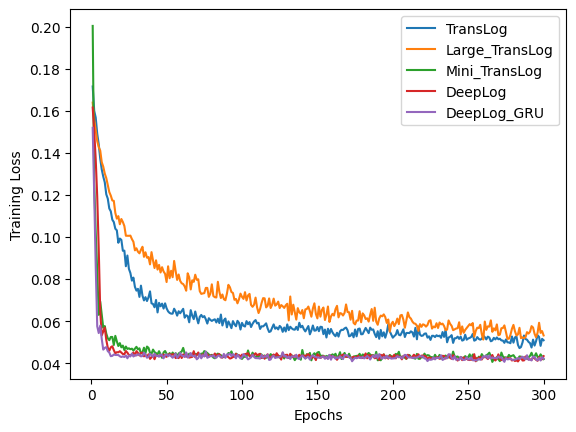

<Figure size 640x480 with 0 Axes>

In [31]:
xx = range(1, num_epochs+1)
for name, train_loss_list in train_loss_dict.items():
    # if name=="Mini_TransLog":
    #     continue
    plt.plot(xx, train_loss_list, label=name)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()
plt.savefig("train_loss.png")
plt.clf()

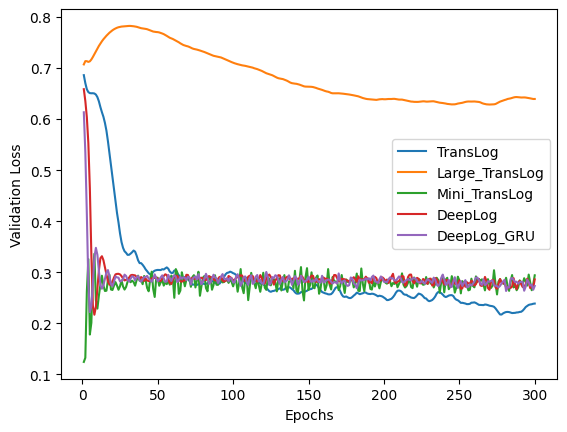

<Figure size 640x480 with 0 Axes>

In [32]:
for name, val_loss_list in val_loss_dict.items():
    # if name=="Mini_TransLog":
    #     continue
    plt.plot(xx, val_loss_list, label=name)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()
plt.savefig("valid_loss.png")
plt.clf()

## Evaluation

In [45]:
from models.model_collects import *

device = torch.device("cpu")
model_dict = dict()

model_path = "saved_models"

large_Tl = Large_TransLog(max_length)
large_Tl.load_state_dict(torch.load(os.path.join(model_path, "best_Large_TransLog.pth"),map_location=device))
model_dict["Large_TransLog"] = large_Tl.eval()

TL = TransLog(max_length).to(device)
TL.load_state_dict(torch.load(os.path.join(model_path, "best_TransLog.pth"),map_location=device))
model_dict["TransLog"] = TL.eval()

mini_TL = Mini_TransLog(max_length).to(device)
mini_TL.load_state_dict(torch.load(os.path.join(model_path, "best_Mini_TransLog.pth"),map_location=device))
model_dict["Mini_TransLog"] = mini_TL.eval()

DL_lstm = DeepLog(input_size = 1, hidden_size=128, device = device).to(device)
DL_lstm.load_state_dict(torch.load(os.path.join(model_path, "best_DeepLog.pth"),map_location=device))
model_dict["DeepLog"] = DL_lstm.eval()

DL_gru = DeepLog_GRU(input_size = 1, hidden_size=128, device = device).to(device)
DL_gru.load_state_dict(torch.load(os.path.join(model_path, "best_DeepLog_GRU.pth"),map_location=device))
model_dict["DeepLog_GRU"] = DL_gru.eval()

In [46]:
x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test).to(torch.int64)
y_test_tensor = F.one_hot(y_test_tensor, num_classes=2)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor.to(torch.float))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

for name, model in model_dict.items():
    pred = []
    for step, (seq, label) in enumerate(test_dataloader):
            seq = seq.clone().detach().view(-1, max_length, 1).to(device)
            output = model(seq)
            pred += torch.argmax(output,dim=1).detach().cpu().tolist()
            loss = criterion(output, label.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    #precision, recall, _ = precision_recall_curve(y_test, pred)
    F1_score = f1_score(y_test, pred)
    print("model= {} F1_score={}".format(name, F1_score))
    # plt.plot(recall, precision,label=name)
    # plt.show()

# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall curve")
# plt.legend()
# plt.show()

model= Large_TransLog F1_score=0.0
model= TransLog F1_score=0.02380952380952381
model= Mini_TransLog F1_score=0.0
model= DeepLog F1_score=0.0
model= DeepLog_GRU F1_score=0.0


In [56]:
log_path = 'logs/structured/HDFS.log_structured.csv'
label_path = 'logs/anomaly_label.csv'
template_path = 'logs/structured/HDFS.log_templates.csv'

x_train_row, y_train_row, x_test_row, y_test_row = dataloader.load_HDFS(
    log_file=log_path,
    label_file=label_path,
    template_file=template_path,
    train_ratio=0.7,
    save_csv=False)

In [74]:
print(x_train_row.shape)
print(x_test_row.shape)
num = []
for i in range(x_train_row.shape[0]):
    len = np.count_nonzero(x_train_row[i,:])
    num.append(len)
for i in range(x_test_row.shape[0]):
    len = np.count_nonzero(x_test_row[i,:])
    num.append(len)
print(max(num))

(402542, 298)
(172519, 284)
298


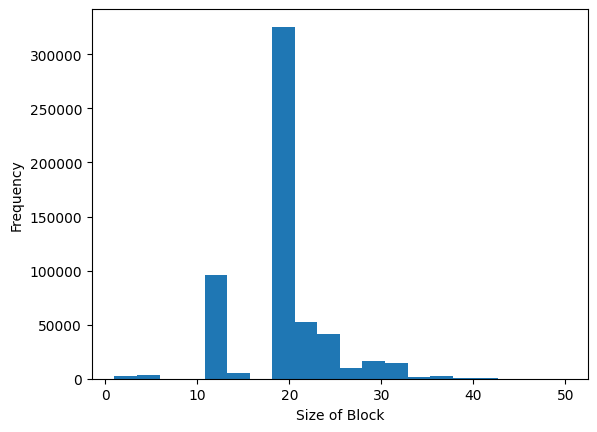

In [77]:
plt.hist(num, bins=20, range=(1, 50))
plt.xlabel('Size of Block')
plt.ylabel('Frequency')
plt.show()